In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import datacube

import matplotlib.pyplot as plt
import matplotlib.cm as color_maps  
from matplotlib.pyplot import figure, cm

import json
import time
import sys
import os

import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
from rasterio.plot import show

import rioxarray as rio

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import ogr, gdal

from datetime import datetime
#from time import time

import skimage
from skimage import exposure
from skimage import morphology
from skimage.morphology import disk
from skimage.morphology import rectangle
from skimage.filters import rank

import glob
import fiona
import subprocess

import utils.data_cube_utilities.dc_utilities as utils
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr, write_png_from_xr
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_mosaic
from utils.data_cube_utilities.dc_sar_utils import dn_to_db 

from rmmeh.vanilla import rmmeh

In [2]:
def rasterization(InputVector,OutputImage,RefImage):
    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    print(Image)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterising
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)


    print("Done.")

    print('finist_rasterise_vector')
    
def rgb(dataset, bands = ['nir', 'red', 'green'], paint_on_mask = []):
    
    fig=plt.figure()
    fig.set_size_inches(9, 9)
    
    rgb = np.stack([dataset[bands[0]], dataset[bands[1]], dataset[bands[2]]], axis = -1)
    rgb = rgb.astype(np.float32)

    p2, p98 = np.percentile(rgb, (2, 98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98)) * 255.0

    rgb = rgb.astype(int) 

    for mask, color in paint_on_mask:        
        rgb[mask] = np.array([256,256,256]) - np.array(color).astype(np.int16)
    plt.imshow(rgb)
        
def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
      
    clear_pixels = dataset.pixel_qa.values == (2 ) 
    water_pixels = dataset.pixel_qa.values == (4 )
    shadow_pixels= dataset.pixel_qa.values == (3 )
           
    #a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    a_clean_mask = np.logical_or(1, 1)
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    #cloud_free_boolean_mask = generate_cloud_mask(dataset)
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

## 1. Initialization

In [3]:
sugarcane_shp = './shp/clipped_sugarcane.shp'
rice_shp = './shp/clipped_rice.shp'

longitude_extents = (99.6901, 99.8776)
latitude_extents = (16.5634, 16.4344)

platform = "SENTINEL_2_Thailand"
product = "s2_level2a_Thailand"
                      
bands = ['coastal', 
         'blue', 'green', 'red', 
         #'veg5', 'veg6', 'veg7', 
         'nir', 'narrow_nir', 
         #'water_vapour', 'swir1', 'swir2', 
         'AOT', 'pixel_qa']
         #'SCL', 'WVP', 'AOT', 'pixel_qa']

dc = datacube.Datacube(app = 'my_app', config = '/home/ubuntu/.datacubeThailandS2.conf')

time_extents = ('2017-01-01', '2021-05-31')
#time_extents = ('2020-01-01', '2021-05-31')

n_sample = 10000
safety_factor = 1.5

result_file = ("x_train", "y_train")

## 2. Get sentinel2 data from ODC as the same size and resolution of input raster

In [4]:
start_time = time.time()
print("Mem status before loading dataset")
!cat /proc/meminfo | grep Mem

s2_dataset = dc.load(latitude = latitude_extents,
                     longitude = longitude_extents,
                     #latitude = (latitude_extents[0], midpoint[0]),
                     #longitude = (longitude_extents[0], midpoint[1]),
                     platform = platform,
                     time = time_extents,
                     product = product,
                     measurements = bands)

print("loading time:", time.time() - start_time,"Sec.")

print("Mem status after dataset loaded")
!cat /proc/meminfo | grep Mem


Mem status before loading dataset
MemTotal:       132028380 kB
MemFree:        79786320 kB
MemAvailable:   110072836 kB
loading time: 130.84961771965027 Sec.
Mem status after dataset loaded
MemTotal:       132028380 kB
MemFree:        72757156 kB
MemAvailable:   103042980 kB


In [5]:
#s2_dataset.to_netcdf("odc_on_disk.nc")

s2_dataset

<xarray.Dataset>
Dimensions:     (latitude: 1394, longitude: 2026, time: 156)
Coordinates:
  * time        (time) datetime64[ns] 2019-05-05T04:03:48.860000 ... 2021-05-29T04:03:41.640000
  * latitude    (latitude) float64 16.56 16.56 16.56 16.56 ... 16.43 16.43 16.43
  * longitude   (longitude) float64 99.69 99.69 99.69 ... 99.88 99.88 99.88
Data variables:
    coastal     (time, latitude, longitude) int16 652 652 652 ... 5152 5152 5152
    blue        (time, latitude, longitude) int16 880 821 893 ... 5436 5296 5124
    green       (time, latitude, longitude) int16 1200 1228 1242 ... 4852 4852
    red         (time, latitude, longitude) int16 1214 1192 1306 ... 4544 4528
    nir         (time, latitude, longitude) int16 2930 3012 3068 ... 5036 4972
    narrow_nir  (time, latitude, longitude) int16 3222 3222 3408 ... 5194 5194
    AOT         (time, latitude, longitude) int16 456 456 456 ... 204 204 204
    pixel_qa    (time, latitude, longitude) int16 5 5 5 5 5 5 5 ... 9 9 9 9 9 9
Attributes:
    crs:      EPSG:4326

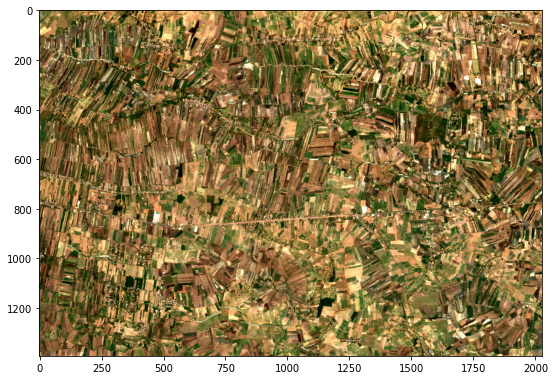

In [6]:
s2_mosaic=mrf_mosaic(s2_dataset)
s2_mosaic

#draw image
rgb(s2_mosaic, bands=['red','green','blue'])

#save mosaic to GeoTIFF and will be use as RefImage 
measurements = ['red', 'green', 'blue']
RefImage = './refImage.tif'
write_geotiff_from_xr(RefImage, s2_mosaic, measurements)

In [7]:
#Image area in sq.km.
1652*1317*(100)/(1000*1000)

217.5684

## 1. read shape file

In [8]:
def records(file):  
    # generator 
    reader = ogr.Open(file)
    layer = reader.GetLayer(0)
    result = []
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        polygon = json.loads(feature.ExportToJson())
        geojson = json.dumps(polygon['geometry'])
        tmp_polygon = ogr.CreateGeometryFromJson(geojson)
        result.append(tmp_polygon)
    return result
        
def in_polygon(lat, lon, shp_records):
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(lon, lat)

    for i, polygon in enumerate(shp_records):
        if point.Within(polygon):
            return True
        
    return False

In [9]:
sugarcane_area = records(sugarcane_shp)
rice_area = records(rice_shp)

In [10]:
#try in-polygon test
sugar_point = (16.4006, 99.7045)
rice_point = (16.3647, 99.6797)

print("is sugar_point in sugar_area", in_polygon(sugar_point[0], sugar_point[1], sugarcane_area))
print("is sugar_point in rice_area", in_polygon(sugar_point[0], sugar_point[1], rice_area))
print("is rice_point in sugar_area", in_polygon(rice_point[0], rice_point[1], sugarcane_area))
print("is rice_point in rice_area", in_polygon(rice_point[0], rice_point[1], rice_area))

is sugar_point in sugar_area True
is sugar_point in rice_area False
is rice_point in sugar_area False
is rice_point in rice_area True


## 3. Sampling locations from (1.)

In [11]:
s2_dataset.latitude.data

array([16.5634083, 16.5633157, 16.5632231, ..., 16.4346017, 16.4345091,
       16.4344165])

In [12]:
import random

#list of (lat,lon)
sugarcane_points = []
rice_points = []
other_points = []

#n_sample = 5
count = 0

print("start_sampling n=",(len(s2_dataset.latitude.data)*len(s2_dataset.longitude.data)))

#while len(sugarcane_points) < n_sample*safety_factor or len(rice_points) < n_sample*safety_factor :
for i in range(len(s2_dataset.latitude.data)) : 
    for j in range(len(s2_dataset.longitude.data)) : 
        lat = s2_dataset.latitude.data[i]
        lon = s2_dataset.longitude.data[j]


        if in_polygon(lat, lon, sugarcane_area):
            #print(lat, lon)
            #print("sugar")
            sugarcane_points.append((lat,lon))
        elif in_polygon(lat, lon, rice_area):
            #print(lat, lon)
            #print("rice")
            rice_points.append((lat,lon))
        elif  len(other_points): 
            other_points.append((lat,lon))

        count += 1
        if count<10 or count%300 == 0:
            print("iteration:", count, "sugarcane_points:", len(sugarcane_points), "rice_points:", len(rice_points), "other_points:", len(other_points))


start_sampling n= 2824244
iteration: 1 sugarcane_points: 1 rice_points: 0 other_points: 0
iteration: 2 sugarcane_points: 2 rice_points: 0 other_points: 0
iteration: 3 sugarcane_points: 3 rice_points: 0 other_points: 0
iteration: 4 sugarcane_points: 4 rice_points: 0 other_points: 0
iteration: 5 sugarcane_points: 5 rice_points: 0 other_points: 0
iteration: 6 sugarcane_points: 6 rice_points: 0 other_points: 0
iteration: 7 sugarcane_points: 7 rice_points: 0 other_points: 0
iteration: 8 sugarcane_points: 8 rice_points: 0 other_points: 0
iteration: 9 sugarcane_points: 9 rice_points: 0 other_points: 0
iteration: 300 sugarcane_points: 253 rice_points: 0 other_points: 0
iteration: 600 sugarcane_points: 420 rice_points: 0 other_points: 0
iteration: 900 sugarcane_points: 657 rice_points: 53 other_points: 0
iteration: 1200 sugarcane_points: 957 rice_points: 53 other_points: 0
iteration: 1500 sugarcane_points: 1208 rice_points: 53 other_points: 0
iteration: 1800 sugarcane_points: 1462 rice_points: 

iteration: 31500 sugarcane_points: 22679 rice_points: 2934 other_points: 0
iteration: 31800 sugarcane_points: 22950 rice_points: 2934 other_points: 0
iteration: 32100 sugarcane_points: 23123 rice_points: 3001 other_points: 0
iteration: 32400 sugarcane_points: 23223 rice_points: 3095 other_points: 0
iteration: 32700 sugarcane_points: 23452 rice_points: 3095 other_points: 0
iteration: 33000 sugarcane_points: 23609 rice_points: 3095 other_points: 0
iteration: 33300 sugarcane_points: 23807 rice_points: 3181 other_points: 0
iteration: 33600 sugarcane_points: 24107 rice_points: 3181 other_points: 0
iteration: 33900 sugarcane_points: 24343 rice_points: 3181 other_points: 0
iteration: 34200 sugarcane_points: 24531 rice_points: 3266 other_points: 0
iteration: 34500 sugarcane_points: 24661 rice_points: 3339 other_points: 0
iteration: 34800 sugarcane_points: 24864 rice_points: 3339 other_points: 0
iteration: 35100 sugarcane_points: 25061 rice_points: 3339 other_points: 0
iteration: 35400 sugarcan

iteration: 64500 sugarcane_points: 45675 rice_points: 7371 other_points: 0
iteration: 64800 sugarcane_points: 45736 rice_points: 7574 other_points: 0
iteration: 65100 sugarcane_points: 45985 rice_points: 7575 other_points: 0
iteration: 65400 sugarcane_points: 46169 rice_points: 7575 other_points: 0
iteration: 65700 sugarcane_points: 46391 rice_points: 7646 other_points: 0
iteration: 66000 sugarcane_points: 46691 rice_points: 7646 other_points: 0
iteration: 66300 sugarcane_points: 46909 rice_points: 7646 other_points: 0
iteration: 66600 sugarcane_points: 47040 rice_points: 7765 other_points: 0
iteration: 66900 sugarcane_points: 47131 rice_points: 7956 other_points: 0
iteration: 67200 sugarcane_points: 47348 rice_points: 7967 other_points: 0
iteration: 67500 sugarcane_points: 47557 rice_points: 7967 other_points: 0
iteration: 67800 sugarcane_points: 47773 rice_points: 8044 other_points: 0
iteration: 68100 sugarcane_points: 48062 rice_points: 8044 other_points: 0
iteration: 68400 sugarcan

iteration: 97200 sugarcane_points: 65383 rice_points: 15288 other_points: 0
iteration: 97500 sugarcane_points: 65558 rice_points: 15376 other_points: 0
iteration: 97800 sugarcane_points: 65708 rice_points: 15412 other_points: 0
iteration: 98100 sugarcane_points: 65902 rice_points: 15500 other_points: 0
iteration: 98400 sugarcane_points: 66190 rice_points: 15500 other_points: 0
iteration: 98700 sugarcane_points: 66458 rice_points: 15500 other_points: 0
iteration: 99000 sugarcane_points: 66554 rice_points: 15677 other_points: 0
iteration: 99300 sugarcane_points: 66593 rice_points: 15847 other_points: 0
iteration: 99600 sugarcane_points: 66761 rice_points: 15958 other_points: 0
iteration: 99900 sugarcane_points: 66948 rice_points: 15958 other_points: 0
iteration: 100200 sugarcane_points: 67142 rice_points: 16047 other_points: 0
iteration: 100500 sugarcane_points: 67430 rice_points: 16047 other_points: 0
iteration: 100800 sugarcane_points: 67665 rice_points: 16080 other_points: 0
iteration

iteration: 129300 sugarcane_points: 83797 rice_points: 25134 other_points: 0
iteration: 129600 sugarcane_points: 83801 rice_points: 25372 other_points: 0
iteration: 129900 sugarcane_points: 83937 rice_points: 25523 other_points: 0
iteration: 130200 sugarcane_points: 84035 rice_points: 25642 other_points: 0
iteration: 130500 sugarcane_points: 84255 rice_points: 25718 other_points: 0
iteration: 130800 sugarcane_points: 84520 rice_points: 25740 other_points: 0
iteration: 131100 sugarcane_points: 84794 rice_points: 25740 other_points: 0
iteration: 131400 sugarcane_points: 84934 rice_points: 25887 other_points: 0
iteration: 131700 sugarcane_points: 84951 rice_points: 26108 other_points: 0
iteration: 132000 sugarcane_points: 85082 rice_points: 26271 other_points: 0
iteration: 132300 sugarcane_points: 85246 rice_points: 26332 other_points: 0
iteration: 132600 sugarcane_points: 85439 rice_points: 26429 other_points: 0
iteration: 132900 sugarcane_points: 85721 rice_points: 26429 other_points: 0

iteration: 161400 sugarcane_points: 100582 rice_points: 36314 other_points: 0
iteration: 161700 sugarcane_points: 100803 rice_points: 36389 other_points: 0
iteration: 162000 sugarcane_points: 100807 rice_points: 36636 other_points: 0
iteration: 162300 sugarcane_points: 100911 rice_points: 36811 other_points: 0
iteration: 162600 sugarcane_points: 100987 rice_points: 36985 other_points: 0
iteration: 162900 sugarcane_points: 101258 rice_points: 37014 other_points: 0
iteration: 163200 sugarcane_points: 101494 rice_points: 37014 other_points: 0
iteration: 163500 sugarcane_points: 101731 rice_points: 37014 other_points: 0
iteration: 163800 sugarcane_points: 101879 rice_points: 37163 other_points: 0
iteration: 164100 sugarcane_points: 101884 rice_points: 37407 other_points: 0
iteration: 164400 sugarcane_points: 101982 rice_points: 37582 other_points: 0
iteration: 164700 sugarcane_points: 102131 rice_points: 37682 other_points: 0
iteration: 165000 sugarcane_points: 102359 rice_points: 37717 ot

iteration: 193200 sugarcane_points: 116494 rice_points: 47257 other_points: 0
iteration: 193500 sugarcane_points: 116718 rice_points: 47301 other_points: 0
iteration: 193800 sugarcane_points: 116929 rice_points: 47301 other_points: 0
iteration: 194100 sugarcane_points: 117098 rice_points: 47358 other_points: 0
iteration: 194400 sugarcane_points: 117111 rice_points: 47590 other_points: 0
iteration: 194700 sugarcane_points: 117191 rice_points: 47764 other_points: 0
iteration: 195000 sugarcane_points: 117235 rice_points: 47973 other_points: 0
iteration: 195300 sugarcane_points: 117487 rice_points: 48021 other_points: 0
iteration: 195600 sugarcane_points: 117697 rice_points: 48059 other_points: 0
iteration: 195900 sugarcane_points: 117922 rice_points: 48059 other_points: 0
iteration: 196200 sugarcane_points: 118043 rice_points: 48178 other_points: 0
iteration: 196500 sugarcane_points: 118043 rice_points: 48418 other_points: 0
iteration: 196800 sugarcane_points: 118116 rice_points: 48599 ot

iteration: 225000 sugarcane_points: 129602 rice_points: 61016 other_points: 0
iteration: 225300 sugarcane_points: 129602 rice_points: 61306 other_points: 0
iteration: 225600 sugarcane_points: 129771 rice_points: 61390 other_points: 0
iteration: 225900 sugarcane_points: 129957 rice_points: 61444 other_points: 0
iteration: 226200 sugarcane_points: 130067 rice_points: 61444 other_points: 0
iteration: 226500 sugarcane_points: 130270 rice_points: 61539 other_points: 0
iteration: 226800 sugarcane_points: 130276 rice_points: 61833 other_points: 0
iteration: 227100 sugarcane_points: 130276 rice_points: 62101 other_points: 0
iteration: 227400 sugarcane_points: 130294 rice_points: 62351 other_points: 0
iteration: 227700 sugarcane_points: 130498 rice_points: 62430 other_points: 0
iteration: 228000 sugarcane_points: 130639 rice_points: 62468 other_points: 0
iteration: 228300 sugarcane_points: 130791 rice_points: 62468 other_points: 0
iteration: 228600 sugarcane_points: 130919 rice_points: 62638 ot

iteration: 256800 sugarcane_points: 138130 rice_points: 77574 other_points: 0
iteration: 257100 sugarcane_points: 138158 rice_points: 77844 other_points: 0
iteration: 257400 sugarcane_points: 138158 rice_points: 78144 other_points: 0
iteration: 257700 sugarcane_points: 138158 rice_points: 78438 other_points: 0
iteration: 258000 sugarcane_points: 138224 rice_points: 78587 other_points: 0
iteration: 258300 sugarcane_points: 138296 rice_points: 78636 other_points: 0
iteration: 258600 sugarcane_points: 138472 rice_points: 78636 other_points: 0
iteration: 258900 sugarcane_points: 138646 rice_points: 78760 other_points: 0
iteration: 259200 sugarcane_points: 138672 rice_points: 79031 other_points: 0
iteration: 259500 sugarcane_points: 138672 rice_points: 79329 other_points: 0
iteration: 259800 sugarcane_points: 138672 rice_points: 79593 other_points: 0
iteration: 260100 sugarcane_points: 138745 rice_points: 79748 other_points: 0
iteration: 260400 sugarcane_points: 138842 rice_points: 79748 ot

iteration: 288600 sugarcane_points: 146202 rice_points: 95063 other_points: 0
iteration: 288900 sugarcane_points: 146344 rice_points: 95120 other_points: 0
iteration: 289200 sugarcane_points: 146595 rice_points: 95159 other_points: 0
iteration: 289500 sugarcane_points: 146651 rice_points: 95401 other_points: 0
iteration: 289800 sugarcane_points: 146651 rice_points: 95692 other_points: 0
iteration: 290100 sugarcane_points: 146651 rice_points: 95933 other_points: 0
iteration: 290400 sugarcane_points: 146680 rice_points: 96032 other_points: 0
iteration: 290700 sugarcane_points: 146735 rice_points: 96174 other_points: 0
iteration: 291000 sugarcane_points: 146928 rice_points: 96222 other_points: 0
iteration: 291300 sugarcane_points: 147148 rice_points: 96300 other_points: 0
iteration: 291600 sugarcane_points: 147170 rice_points: 96578 other_points: 0
iteration: 291900 sugarcane_points: 147170 rice_points: 96867 other_points: 0
iteration: 292200 sugarcane_points: 147170 rice_points: 97047 ot

iteration: 320100 sugarcane_points: 153841 rice_points: 114161 other_points: 0
iteration: 320400 sugarcane_points: 153841 rice_points: 114426 other_points: 0
iteration: 320700 sugarcane_points: 153895 rice_points: 114610 other_points: 0
iteration: 321000 sugarcane_points: 153911 rice_points: 114848 other_points: 0
iteration: 321300 sugarcane_points: 153992 rice_points: 114983 other_points: 0
iteration: 321600 sugarcane_points: 154225 rice_points: 115039 other_points: 0
iteration: 321900 sugarcane_points: 154293 rice_points: 115269 other_points: 0
iteration: 322200 sugarcane_points: 154293 rice_points: 115551 other_points: 0
iteration: 322500 sugarcane_points: 154293 rice_points: 115835 other_points: 0
iteration: 322800 sugarcane_points: 154362 rice_points: 115980 other_points: 0
iteration: 323100 sugarcane_points: 154390 rice_points: 116208 other_points: 0
iteration: 323400 sugarcane_points: 154488 rice_points: 116343 other_points: 0
iteration: 323700 sugarcane_points: 154712 rice_poin

iteration: 351300 sugarcane_points: 160696 rice_points: 135644 other_points: 0
iteration: 351600 sugarcane_points: 160808 rice_points: 135821 other_points: 0
iteration: 351900 sugarcane_points: 160883 rice_points: 136024 other_points: 0
iteration: 352200 sugarcane_points: 160974 rice_points: 136222 other_points: 0
iteration: 352500 sugarcane_points: 160999 rice_points: 136496 other_points: 0
iteration: 352800 sugarcane_points: 160999 rice_points: 136759 other_points: 0
iteration: 353100 sugarcane_points: 161039 rice_points: 137007 other_points: 0
iteration: 353400 sugarcane_points: 161083 rice_points: 137219 other_points: 0
iteration: 353700 sugarcane_points: 161210 rice_points: 137378 other_points: 0
iteration: 354000 sugarcane_points: 161283 rice_points: 137581 other_points: 0
iteration: 354300 sugarcane_points: 161368 rice_points: 137786 other_points: 0
iteration: 354600 sugarcane_points: 161368 rice_points: 138086 other_points: 0
iteration: 354900 sugarcane_points: 161368 rice_poin

iteration: 382500 sugarcane_points: 165730 rice_points: 159527 other_points: 0
iteration: 382800 sugarcane_points: 165756 rice_points: 159795 other_points: 0
iteration: 383100 sugarcane_points: 165756 rice_points: 160048 other_points: 0
iteration: 383400 sugarcane_points: 165756 rice_points: 160323 other_points: 0
iteration: 383700 sugarcane_points: 165822 rice_points: 160501 other_points: 0
iteration: 384000 sugarcane_points: 165920 rice_points: 160661 other_points: 0
iteration: 384300 sugarcane_points: 165972 rice_points: 160894 other_points: 0
iteration: 384600 sugarcane_points: 166004 rice_points: 161158 other_points: 0
iteration: 384900 sugarcane_points: 166030 rice_points: 161426 other_points: 0
iteration: 385200 sugarcane_points: 166030 rice_points: 161674 other_points: 0
iteration: 385500 sugarcane_points: 166057 rice_points: 161930 other_points: 0
iteration: 385800 sugarcane_points: 166097 rice_points: 162114 other_points: 0
iteration: 386100 sugarcane_points: 166223 rice_poin

iteration: 413700 sugarcane_points: 169630 rice_points: 183688 other_points: 0
iteration: 414000 sugarcane_points: 169677 rice_points: 183894 other_points: 0
iteration: 414300 sugarcane_points: 169725 rice_points: 184116 other_points: 0
iteration: 414600 sugarcane_points: 169802 rice_points: 184315 other_points: 0
iteration: 414900 sugarcane_points: 169823 rice_points: 184589 other_points: 0
iteration: 415200 sugarcane_points: 169866 rice_points: 184816 other_points: 0
iteration: 415500 sugarcane_points: 169866 rice_points: 185096 other_points: 0
iteration: 415800 sugarcane_points: 169866 rice_points: 185342 other_points: 0
iteration: 416100 sugarcane_points: 169915 rice_points: 185551 other_points: 0
iteration: 416400 sugarcane_points: 170008 rice_points: 185719 other_points: 0
iteration: 416700 sugarcane_points: 170044 rice_points: 185969 other_points: 0
iteration: 417000 sugarcane_points: 170056 rice_points: 186252 other_points: 0
iteration: 417300 sugarcane_points: 170099 rice_poin

iteration: 444900 sugarcane_points: 173523 rice_points: 208176 other_points: 0
iteration: 445200 sugarcane_points: 173523 rice_points: 208476 other_points: 0
iteration: 445500 sugarcane_points: 173566 rice_points: 208733 other_points: 0
iteration: 445800 sugarcane_points: 173566 rice_points: 209010 other_points: 0
iteration: 446100 sugarcane_points: 173570 rice_points: 209249 other_points: 0
iteration: 446400 sugarcane_points: 173647 rice_points: 209420 other_points: 0
iteration: 446700 sugarcane_points: 173672 rice_points: 209647 other_points: 0
iteration: 447000 sugarcane_points: 173757 rice_points: 209832 other_points: 0
iteration: 447300 sugarcane_points: 173757 rice_points: 210132 other_points: 0
iteration: 447600 sugarcane_points: 173799 rice_points: 210390 other_points: 0
iteration: 447900 sugarcane_points: 173804 rice_points: 210662 other_points: 0
iteration: 448200 sugarcane_points: 173808 rice_points: 210887 other_points: 0
iteration: 448500 sugarcane_points: 173884 rice_poin

iteration: 476100 sugarcane_points: 176303 rice_points: 232849 other_points: 0
iteration: 476400 sugarcane_points: 176313 rice_points: 233121 other_points: 0
iteration: 476700 sugarcane_points: 176339 rice_points: 233296 other_points: 0
iteration: 477000 sugarcane_points: 176358 rice_points: 233528 other_points: 0
iteration: 477300 sugarcane_points: 176405 rice_points: 233726 other_points: 0
iteration: 477600 sugarcane_points: 176405 rice_points: 234026 other_points: 0
iteration: 477900 sugarcane_points: 176447 rice_points: 234284 other_points: 0
iteration: 478200 sugarcane_points: 176474 rice_points: 234556 other_points: 0
iteration: 478500 sugarcane_points: 176474 rice_points: 234799 other_points: 0
iteration: 478800 sugarcane_points: 176518 rice_points: 234983 other_points: 0
iteration: 479100 sugarcane_points: 176522 rice_points: 235243 other_points: 0
iteration: 479400 sugarcane_points: 176567 rice_points: 235455 other_points: 0
iteration: 479700 sugarcane_points: 176567 rice_poin

iteration: 507300 sugarcane_points: 178803 rice_points: 258505 other_points: 0
iteration: 507600 sugarcane_points: 178851 rice_points: 258727 other_points: 0
iteration: 507900 sugarcane_points: 178883 rice_points: 258983 other_points: 0
iteration: 508200 sugarcane_points: 178883 rice_points: 259283 other_points: 0
iteration: 508500 sugarcane_points: 178943 rice_points: 259523 other_points: 0
iteration: 508800 sugarcane_points: 178959 rice_points: 259790 other_points: 0
iteration: 509100 sugarcane_points: 178994 rice_points: 260000 other_points: 0
iteration: 509400 sugarcane_points: 178994 rice_points: 260276 other_points: 0
iteration: 509700 sugarcane_points: 179073 rice_points: 260460 other_points: 0
iteration: 510000 sugarcane_points: 179073 rice_points: 260754 other_points: 0
iteration: 510300 sugarcane_points: 179112 rice_points: 261015 other_points: 0
iteration: 510600 sugarcane_points: 179151 rice_points: 261270 other_points: 0
iteration: 510900 sugarcane_points: 179151 rice_poin

iteration: 538500 sugarcane_points: 180750 rice_points: 285372 other_points: 0
iteration: 538800 sugarcane_points: 180765 rice_points: 285631 other_points: 0
iteration: 539100 sugarcane_points: 180795 rice_points: 285875 other_points: 0
iteration: 539400 sugarcane_points: 180801 rice_points: 286153 other_points: 0
iteration: 539700 sugarcane_points: 180820 rice_points: 286408 other_points: 0
iteration: 540000 sugarcane_points: 180840 rice_points: 286667 other_points: 0
iteration: 540300 sugarcane_points: 180840 rice_points: 286947 other_points: 0
iteration: 540600 sugarcane_points: 180840 rice_points: 287247 other_points: 0
iteration: 540900 sugarcane_points: 180876 rice_points: 287485 other_points: 0
iteration: 541200 sugarcane_points: 180888 rice_points: 287736 other_points: 0
iteration: 541500 sugarcane_points: 180912 rice_points: 287990 other_points: 0
iteration: 541800 sugarcane_points: 180912 rice_points: 288265 other_points: 0
iteration: 542100 sugarcane_points: 180933 rice_poin

iteration: 569700 sugarcane_points: 181819 rice_points: 312999 other_points: 0
iteration: 570000 sugarcane_points: 181819 rice_points: 313243 other_points: 0
iteration: 570300 sugarcane_points: 181819 rice_points: 313509 other_points: 0
iteration: 570600 sugarcane_points: 181848 rice_points: 313762 other_points: 0
iteration: 570900 sugarcane_points: 181848 rice_points: 314057 other_points: 0
iteration: 571200 sugarcane_points: 181862 rice_points: 314315 other_points: 0
iteration: 571500 sugarcane_points: 181878 rice_points: 314547 other_points: 0
iteration: 571800 sugarcane_points: 181886 rice_points: 314808 other_points: 0
iteration: 572100 sugarcane_points: 181886 rice_points: 315065 other_points: 0
iteration: 572400 sugarcane_points: 181896 rice_points: 315319 other_points: 0
iteration: 572700 sugarcane_points: 181919 rice_points: 315577 other_points: 0
iteration: 573000 sugarcane_points: 181919 rice_points: 315869 other_points: 0
iteration: 573300 sugarcane_points: 181939 rice_poin

iteration: 600900 sugarcane_points: 183316 rice_points: 338994 other_points: 0
iteration: 601200 sugarcane_points: 183318 rice_points: 339254 other_points: 0
iteration: 601500 sugarcane_points: 183332 rice_points: 339485 other_points: 0
iteration: 601800 sugarcane_points: 183367 rice_points: 339674 other_points: 0
iteration: 602100 sugarcane_points: 183367 rice_points: 339935 other_points: 0
iteration: 602400 sugarcane_points: 183367 rice_points: 340202 other_points: 0
iteration: 602700 sugarcane_points: 183367 rice_points: 340447 other_points: 0
iteration: 603000 sugarcane_points: 183433 rice_points: 340681 other_points: 0
iteration: 603300 sugarcane_points: 183433 rice_points: 340922 other_points: 0
iteration: 603600 sugarcane_points: 183446 rice_points: 341175 other_points: 0
iteration: 603900 sugarcane_points: 183482 rice_points: 341358 other_points: 0
iteration: 604200 sugarcane_points: 183482 rice_points: 341626 other_points: 0
iteration: 604500 sugarcane_points: 183482 rice_poin

iteration: 632100 sugarcane_points: 186025 rice_points: 362272 other_points: 0
iteration: 632400 sugarcane_points: 186031 rice_points: 362465 other_points: 0
iteration: 632700 sugarcane_points: 186061 rice_points: 362690 other_points: 0
iteration: 633000 sugarcane_points: 186070 rice_points: 362928 other_points: 0
iteration: 633300 sugarcane_points: 186167 rice_points: 363121 other_points: 0
iteration: 633600 sugarcane_points: 186232 rice_points: 363320 other_points: 0
iteration: 633900 sugarcane_points: 186232 rice_points: 363547 other_points: 0
iteration: 634200 sugarcane_points: 186288 rice_points: 363702 other_points: 0
iteration: 634500 sugarcane_points: 186308 rice_points: 363935 other_points: 0
iteration: 634800 sugarcane_points: 186335 rice_points: 364137 other_points: 0
iteration: 635100 sugarcane_points: 186335 rice_points: 364401 other_points: 0
iteration: 635400 sugarcane_points: 186471 rice_points: 364551 other_points: 0
iteration: 635700 sugarcane_points: 186504 rice_poin

iteration: 663300 sugarcane_points: 190733 rice_points: 381411 other_points: 0
iteration: 663600 sugarcane_points: 190750 rice_points: 381650 other_points: 0
iteration: 663900 sugarcane_points: 190922 rice_points: 381763 other_points: 0
iteration: 664200 sugarcane_points: 190990 rice_points: 381908 other_points: 0
iteration: 664500 sugarcane_points: 191017 rice_points: 382001 other_points: 0
iteration: 664800 sugarcane_points: 191055 rice_points: 382164 other_points: 0
iteration: 665100 sugarcane_points: 191125 rice_points: 382328 other_points: 0
iteration: 665400 sugarcane_points: 191135 rice_points: 382536 other_points: 0
iteration: 665700 sugarcane_points: 191227 rice_points: 382724 other_points: 0
iteration: 666000 sugarcane_points: 191339 rice_points: 382872 other_points: 0
iteration: 666300 sugarcane_points: 191397 rice_points: 382987 other_points: 0
iteration: 666600 sugarcane_points: 191436 rice_points: 383095 other_points: 0
iteration: 666900 sugarcane_points: 191485 rice_poin

iteration: 694500 sugarcane_points: 198088 rice_points: 398149 other_points: 0
iteration: 694800 sugarcane_points: 198130 rice_points: 398328 other_points: 0
iteration: 695100 sugarcane_points: 198166 rice_points: 398410 other_points: 0
iteration: 695400 sugarcane_points: 198260 rice_points: 398583 other_points: 0
iteration: 695700 sugarcane_points: 198323 rice_points: 398695 other_points: 0
iteration: 696000 sugarcane_points: 198333 rice_points: 398929 other_points: 0
iteration: 696300 sugarcane_points: 198465 rice_points: 399097 other_points: 0
iteration: 696600 sugarcane_points: 198583 rice_points: 399265 other_points: 0
iteration: 696900 sugarcane_points: 198635 rice_points: 399377 other_points: 0
iteration: 697200 sugarcane_points: 198671 rice_points: 399500 other_points: 0
iteration: 697500 sugarcane_points: 198805 rice_points: 399624 other_points: 0
iteration: 697800 sugarcane_points: 198813 rice_points: 399766 other_points: 0
iteration: 698100 sugarcane_points: 198897 rice_poin

iteration: 725700 sugarcane_points: 205300 rice_points: 414230 other_points: 0
iteration: 726000 sugarcane_points: 205374 rice_points: 414291 other_points: 0
iteration: 726300 sugarcane_points: 205374 rice_points: 414544 other_points: 0
iteration: 726600 sugarcane_points: 205511 rice_points: 414686 other_points: 0
iteration: 726900 sugarcane_points: 205647 rice_points: 414825 other_points: 0
iteration: 727200 sugarcane_points: 205674 rice_points: 415035 other_points: 0
iteration: 727500 sugarcane_points: 205693 rice_points: 415116 other_points: 0
iteration: 727800 sugarcane_points: 205791 rice_points: 415274 other_points: 0
iteration: 728100 sugarcane_points: 205847 rice_points: 415357 other_points: 0
iteration: 728400 sugarcane_points: 205847 rice_points: 415594 other_points: 0
iteration: 728700 sugarcane_points: 205993 rice_points: 415741 other_points: 0
iteration: 729000 sugarcane_points: 206132 rice_points: 415879 other_points: 0
iteration: 729300 sugarcane_points: 206143 rice_poin

iteration: 756900 sugarcane_points: 213025 rice_points: 429113 other_points: 0
iteration: 757200 sugarcane_points: 213167 rice_points: 429239 other_points: 0
iteration: 757500 sugarcane_points: 213249 rice_points: 429426 other_points: 0
iteration: 757800 sugarcane_points: 213306 rice_points: 429492 other_points: 0
iteration: 758100 sugarcane_points: 213392 rice_points: 429644 other_points: 0
iteration: 758400 sugarcane_points: 213414 rice_points: 429757 other_points: 0
iteration: 758700 sugarcane_points: 213414 rice_points: 429989 other_points: 0
iteration: 759000 sugarcane_points: 213583 rice_points: 430106 other_points: 0
iteration: 759300 sugarcane_points: 213742 rice_points: 430215 other_points: 0
iteration: 759600 sugarcane_points: 213788 rice_points: 430419 other_points: 0
iteration: 759900 sugarcane_points: 213836 rice_points: 430520 other_points: 0
iteration: 760200 sugarcane_points: 213914 rice_points: 430674 other_points: 0
iteration: 760500 sugarcane_points: 213935 rice_poin

iteration: 788100 sugarcane_points: 221348 rice_points: 444925 other_points: 0
iteration: 788400 sugarcane_points: 221420 rice_points: 445019 other_points: 0
iteration: 788700 sugarcane_points: 221451 rice_points: 445190 other_points: 0
iteration: 789000 sugarcane_points: 221457 rice_points: 445374 other_points: 0
iteration: 789300 sugarcane_points: 221587 rice_points: 445530 other_points: 0
iteration: 789600 sugarcane_points: 221765 rice_points: 445629 other_points: 0
iteration: 789900 sugarcane_points: 221822 rice_points: 445848 other_points: 0
iteration: 790200 sugarcane_points: 221953 rice_points: 445933 other_points: 0
iteration: 790500 sugarcane_points: 222017 rice_points: 446064 other_points: 0
iteration: 790800 sugarcane_points: 222031 rice_points: 446224 other_points: 0
iteration: 791100 sugarcane_points: 222049 rice_points: 446432 other_points: 0
iteration: 791400 sugarcane_points: 222218 rice_points: 446549 other_points: 0
iteration: 791700 sugarcane_points: 222374 rice_poin

iteration: 819300 sugarcane_points: 229839 rice_points: 460219 other_points: 0
iteration: 819600 sugarcane_points: 229899 rice_points: 460442 other_points: 0
iteration: 819900 sugarcane_points: 230106 rice_points: 460511 other_points: 0
iteration: 820200 sugarcane_points: 230220 rice_points: 460663 other_points: 0
iteration: 820500 sugarcane_points: 230342 rice_points: 460787 other_points: 0
iteration: 820800 sugarcane_points: 230387 rice_points: 460893 other_points: 0
iteration: 821100 sugarcane_points: 230429 rice_points: 461053 other_points: 0
iteration: 821400 sugarcane_points: 230429 rice_points: 461248 other_points: 0
iteration: 821700 sugarcane_points: 230554 rice_points: 461403 other_points: 0
iteration: 822000 sugarcane_points: 230759 rice_points: 461470 other_points: 0
iteration: 822300 sugarcane_points: 230852 rice_points: 461624 other_points: 0
iteration: 822600 sugarcane_points: 230932 rice_points: 461764 other_points: 0
iteration: 822900 sugarcane_points: 230999 rice_poin

iteration: 850500 sugarcane_points: 237579 rice_points: 473551 other_points: 0
iteration: 850800 sugarcane_points: 237706 rice_points: 473623 other_points: 0
iteration: 851100 sugarcane_points: 237739 rice_points: 473745 other_points: 0
iteration: 851400 sugarcane_points: 237822 rice_points: 473790 other_points: 0
iteration: 851700 sugarcane_points: 237822 rice_points: 473984 other_points: 0
iteration: 852000 sugarcane_points: 237855 rice_points: 474180 other_points: 0
iteration: 852300 sugarcane_points: 237986 rice_points: 474246 other_points: 0
iteration: 852600 sugarcane_points: 238034 rice_points: 474434 other_points: 0
iteration: 852900 sugarcane_points: 238152 rice_points: 474520 other_points: 0
iteration: 853200 sugarcane_points: 238204 rice_points: 474575 other_points: 0
iteration: 853500 sugarcane_points: 238263 rice_points: 474682 other_points: 0
iteration: 853800 sugarcane_points: 238263 rice_points: 474876 other_points: 0
iteration: 854100 sugarcane_points: 238365 rice_poin

iteration: 881700 sugarcane_points: 245126 rice_points: 485202 other_points: 0
iteration: 882000 sugarcane_points: 245133 rice_points: 485455 other_points: 0
iteration: 882300 sugarcane_points: 245203 rice_points: 485505 other_points: 0
iteration: 882600 sugarcane_points: 245306 rice_points: 485509 other_points: 0
iteration: 882900 sugarcane_points: 245373 rice_points: 485680 other_points: 0
iteration: 883200 sugarcane_points: 245504 rice_points: 485738 other_points: 0
iteration: 883500 sugarcane_points: 245562 rice_points: 485838 other_points: 0
iteration: 883800 sugarcane_points: 245678 rice_points: 485877 other_points: 0
iteration: 884100 sugarcane_points: 245685 rice_points: 486113 other_points: 0
iteration: 884400 sugarcane_points: 245771 rice_points: 486144 other_points: 0
iteration: 884700 sugarcane_points: 245894 rice_points: 486178 other_points: 0
iteration: 885000 sugarcane_points: 245899 rice_points: 486375 other_points: 0
iteration: 885300 sugarcane_points: 246041 rice_poin

iteration: 912900 sugarcane_points: 252832 rice_points: 496606 other_points: 0
iteration: 913200 sugarcane_points: 252867 rice_points: 496844 other_points: 0
iteration: 913500 sugarcane_points: 252913 rice_points: 496943 other_points: 0
iteration: 913800 sugarcane_points: 253022 rice_points: 497051 other_points: 0
iteration: 914100 sugarcane_points: 253138 rice_points: 497069 other_points: 0
iteration: 914400 sugarcane_points: 253138 rice_points: 497327 other_points: 0
iteration: 914700 sugarcane_points: 253178 rice_points: 497434 other_points: 0
iteration: 915000 sugarcane_points: 253325 rice_points: 497450 other_points: 0
iteration: 915300 sugarcane_points: 253325 rice_points: 497703 other_points: 0
iteration: 915600 sugarcane_points: 253398 rice_points: 497804 other_points: 0
iteration: 915900 sugarcane_points: 253532 rice_points: 497897 other_points: 0
iteration: 916200 sugarcane_points: 253596 rice_points: 497938 other_points: 0
iteration: 916500 sugarcane_points: 253596 rice_poin

iteration: 944100 sugarcane_points: 258687 rice_points: 510326 other_points: 0
iteration: 944400 sugarcane_points: 258721 rice_points: 510418 other_points: 0
iteration: 944700 sugarcane_points: 258740 rice_points: 510593 other_points: 0
iteration: 945000 sugarcane_points: 258770 rice_points: 510771 other_points: 0
iteration: 945300 sugarcane_points: 258849 rice_points: 510846 other_points: 0
iteration: 945600 sugarcane_points: 258902 rice_points: 511087 other_points: 0
iteration: 945900 sugarcane_points: 258918 rice_points: 511270 other_points: 0
iteration: 946200 sugarcane_points: 258995 rice_points: 511370 other_points: 0
iteration: 946500 sugarcane_points: 259043 rice_points: 511425 other_points: 0
iteration: 946800 sugarcane_points: 259043 rice_points: 511676 other_points: 0
iteration: 947100 sugarcane_points: 259108 rice_points: 511777 other_points: 0
iteration: 947400 sugarcane_points: 259206 rice_points: 511865 other_points: 0
iteration: 947700 sugarcane_points: 259211 rice_poin

iteration: 975300 sugarcane_points: 263828 rice_points: 526055 other_points: 0
iteration: 975600 sugarcane_points: 263908 rice_points: 526135 other_points: 0
iteration: 975900 sugarcane_points: 264011 rice_points: 526310 other_points: 0
iteration: 976200 sugarcane_points: 264011 rice_points: 526505 other_points: 0
iteration: 976500 sugarcane_points: 264119 rice_points: 526657 other_points: 0
iteration: 976800 sugarcane_points: 264151 rice_points: 526764 other_points: 0
iteration: 977100 sugarcane_points: 264167 rice_points: 526948 other_points: 0
iteration: 977400 sugarcane_points: 264195 rice_points: 527161 other_points: 0
iteration: 977700 sugarcane_points: 264247 rice_points: 527284 other_points: 0
iteration: 978000 sugarcane_points: 264358 rice_points: 527449 other_points: 0
iteration: 978300 sugarcane_points: 264374 rice_points: 527628 other_points: 0
iteration: 978600 sugarcane_points: 264497 rice_points: 527751 other_points: 0
iteration: 978900 sugarcane_points: 264506 rice_poin

iteration: 1006500 sugarcane_points: 268911 rice_points: 542900 other_points: 0
iteration: 1006800 sugarcane_points: 268999 rice_points: 543066 other_points: 0
iteration: 1007100 sugarcane_points: 269018 rice_points: 543242 other_points: 0
iteration: 1007400 sugarcane_points: 269025 rice_points: 543416 other_points: 0
iteration: 1007700 sugarcane_points: 269025 rice_points: 543700 other_points: 0
iteration: 1008000 sugarcane_points: 269074 rice_points: 543779 other_points: 0
iteration: 1008300 sugarcane_points: 269169 rice_points: 543937 other_points: 0
iteration: 1008600 sugarcane_points: 269223 rice_points: 544067 other_points: 0
iteration: 1008900 sugarcane_points: 269319 rice_points: 544257 other_points: 0
iteration: 1009200 sugarcane_points: 269331 rice_points: 544389 other_points: 0
iteration: 1009500 sugarcane_points: 269338 rice_points: 544612 other_points: 0
iteration: 1009800 sugarcane_points: 269338 rice_points: 544852 other_points: 0
iteration: 1010100 sugarcane_points: 269

iteration: 1037400 sugarcane_points: 272586 rice_points: 560289 other_points: 0
iteration: 1037700 sugarcane_points: 272593 rice_points: 560416 other_points: 0
iteration: 1038000 sugarcane_points: 272593 rice_points: 560692 other_points: 0
iteration: 1038300 sugarcane_points: 272597 rice_points: 560897 other_points: 0
iteration: 1038600 sugarcane_points: 272620 rice_points: 561046 other_points: 0
iteration: 1038900 sugarcane_points: 272693 rice_points: 561137 other_points: 0
iteration: 1039200 sugarcane_points: 272722 rice_points: 561333 other_points: 0
iteration: 1039500 sugarcane_points: 272732 rice_points: 561533 other_points: 0
iteration: 1039800 sugarcane_points: 272739 rice_points: 561694 other_points: 0
iteration: 1040100 sugarcane_points: 272739 rice_points: 561963 other_points: 0
iteration: 1040400 sugarcane_points: 272743 rice_points: 562124 other_points: 0
iteration: 1040700 sugarcane_points: 272774 rice_points: 562253 other_points: 0
iteration: 1041000 sugarcane_points: 272

iteration: 1068300 sugarcane_points: 273792 rice_points: 581430 other_points: 0
iteration: 1068600 sugarcane_points: 273802 rice_points: 581687 other_points: 0
iteration: 1068900 sugarcane_points: 273849 rice_points: 581927 other_points: 0
iteration: 1069200 sugarcane_points: 273906 rice_points: 582118 other_points: 0
iteration: 1069500 sugarcane_points: 273906 rice_points: 582312 other_points: 0
iteration: 1069800 sugarcane_points: 273906 rice_points: 582570 other_points: 0
iteration: 1070100 sugarcane_points: 273912 rice_points: 582713 other_points: 0
iteration: 1070400 sugarcane_points: 273912 rice_points: 582956 other_points: 0
iteration: 1070700 sugarcane_points: 273923 rice_points: 583234 other_points: 0
iteration: 1071000 sugarcane_points: 273980 rice_points: 583448 other_points: 0
iteration: 1071300 sugarcane_points: 274032 rice_points: 583626 other_points: 0
iteration: 1071600 sugarcane_points: 274032 rice_points: 583864 other_points: 0
iteration: 1071900 sugarcane_points: 274

iteration: 1099200 sugarcane_points: 275843 rice_points: 604091 other_points: 0
iteration: 1099500 sugarcane_points: 275908 rice_points: 604290 other_points: 0
iteration: 1099800 sugarcane_points: 275947 rice_points: 604490 other_points: 0
iteration: 1100100 sugarcane_points: 275947 rice_points: 604790 other_points: 0
iteration: 1100400 sugarcane_points: 275960 rice_points: 604927 other_points: 0
iteration: 1100700 sugarcane_points: 275973 rice_points: 605154 other_points: 0
iteration: 1101000 sugarcane_points: 275986 rice_points: 605366 other_points: 0
iteration: 1101300 sugarcane_points: 276003 rice_points: 605635 other_points: 0
iteration: 1101600 sugarcane_points: 276090 rice_points: 605807 other_points: 0
iteration: 1101900 sugarcane_points: 276102 rice_points: 606027 other_points: 0
iteration: 1102200 sugarcane_points: 276115 rice_points: 606275 other_points: 0
iteration: 1102500 sugarcane_points: 276118 rice_points: 606448 other_points: 0
iteration: 1102800 sugarcane_points: 276

iteration: 1130100 sugarcane_points: 278584 rice_points: 626673 other_points: 0
iteration: 1130400 sugarcane_points: 278584 rice_points: 626948 other_points: 0
iteration: 1130700 sugarcane_points: 278597 rice_points: 627140 other_points: 0
iteration: 1131000 sugarcane_points: 278608 rice_points: 627332 other_points: 0
iteration: 1131300 sugarcane_points: 278627 rice_points: 627548 other_points: 0
iteration: 1131600 sugarcane_points: 278647 rice_points: 627766 other_points: 0
iteration: 1131900 sugarcane_points: 278708 rice_points: 627999 other_points: 0
iteration: 1132200 sugarcane_points: 278759 rice_points: 628233 other_points: 0
iteration: 1132500 sugarcane_points: 278759 rice_points: 628528 other_points: 0
iteration: 1132800 sugarcane_points: 278772 rice_points: 628665 other_points: 0
iteration: 1133100 sugarcane_points: 278783 rice_points: 628907 other_points: 0
iteration: 1133400 sugarcane_points: 278804 rice_points: 629110 other_points: 0
iteration: 1133700 sugarcane_points: 278

iteration: 1161000 sugarcane_points: 282011 rice_points: 649045 other_points: 0
iteration: 1161300 sugarcane_points: 282029 rice_points: 649223 other_points: 0
iteration: 1161600 sugarcane_points: 282056 rice_points: 649448 other_points: 0
iteration: 1161900 sugarcane_points: 282104 rice_points: 649613 other_points: 0
iteration: 1162200 sugarcane_points: 282164 rice_points: 649850 other_points: 0
iteration: 1162500 sugarcane_points: 282239 rice_points: 650064 other_points: 0
iteration: 1162800 sugarcane_points: 282253 rice_points: 650314 other_points: 0
iteration: 1163100 sugarcane_points: 282268 rice_points: 650515 other_points: 0
iteration: 1163400 sugarcane_points: 282286 rice_points: 650712 other_points: 0
iteration: 1163700 sugarcane_points: 282335 rice_points: 650896 other_points: 0
iteration: 1164000 sugarcane_points: 282397 rice_points: 651088 other_points: 0
iteration: 1164300 sugarcane_points: 282473 rice_points: 651306 other_points: 0
iteration: 1164600 sugarcane_points: 282

iteration: 1191900 sugarcane_points: 286074 rice_points: 670461 other_points: 0
iteration: 1192200 sugarcane_points: 286222 rice_points: 670524 other_points: 0
iteration: 1192500 sugarcane_points: 286222 rice_points: 670822 other_points: 0
iteration: 1192800 sugarcane_points: 286315 rice_points: 671019 other_points: 0
iteration: 1193100 sugarcane_points: 286315 rice_points: 671319 other_points: 0
iteration: 1193400 sugarcane_points: 286333 rice_points: 671548 other_points: 0
iteration: 1193700 sugarcane_points: 286344 rice_points: 671701 other_points: 0
iteration: 1194000 sugarcane_points: 286403 rice_points: 671910 other_points: 0
iteration: 1194300 sugarcane_points: 286514 rice_points: 672024 other_points: 0
iteration: 1194600 sugarcane_points: 286545 rice_points: 672293 other_points: 0
iteration: 1194900 sugarcane_points: 286608 rice_points: 672520 other_points: 0
iteration: 1195200 sugarcane_points: 286611 rice_points: 672787 other_points: 0
iteration: 1195500 sugarcane_points: 286

iteration: 1222800 sugarcane_points: 290899 rice_points: 691254 other_points: 0
iteration: 1223100 sugarcane_points: 290961 rice_points: 691455 other_points: 0
iteration: 1223400 sugarcane_points: 291012 rice_points: 691697 other_points: 0
iteration: 1223700 sugarcane_points: 291026 rice_points: 691960 other_points: 0
iteration: 1224000 sugarcane_points: 291039 rice_points: 692099 other_points: 0
iteration: 1224300 sugarcane_points: 291060 rice_points: 692359 other_points: 0
iteration: 1224600 sugarcane_points: 291231 rice_points: 692404 other_points: 0
iteration: 1224900 sugarcane_points: 291240 rice_points: 692649 other_points: 0
iteration: 1225200 sugarcane_points: 291328 rice_points: 692835 other_points: 0
iteration: 1225500 sugarcane_points: 291354 rice_points: 693101 other_points: 0
iteration: 1225800 sugarcane_points: 291383 rice_points: 693311 other_points: 0
iteration: 1226100 sugarcane_points: 291395 rice_points: 693495 other_points: 0
iteration: 1226400 sugarcane_points: 291

iteration: 1253700 sugarcane_points: 296108 rice_points: 712092 other_points: 0
iteration: 1254000 sugarcane_points: 296132 rice_points: 712356 other_points: 0
iteration: 1254300 sugarcane_points: 296141 rice_points: 712570 other_points: 0
iteration: 1254600 sugarcane_points: 296176 rice_points: 712790 other_points: 0
iteration: 1254900 sugarcane_points: 296324 rice_points: 712907 other_points: 0
iteration: 1255200 sugarcane_points: 296419 rice_points: 713078 other_points: 0
iteration: 1255500 sugarcane_points: 296463 rice_points: 713287 other_points: 0
iteration: 1255800 sugarcane_points: 296507 rice_points: 713517 other_points: 0
iteration: 1256100 sugarcane_points: 296507 rice_points: 713798 other_points: 0
iteration: 1256400 sugarcane_points: 296526 rice_points: 713976 other_points: 0
iteration: 1256700 sugarcane_points: 296566 rice_points: 714212 other_points: 0
iteration: 1257000 sugarcane_points: 296753 rice_points: 714281 other_points: 0
iteration: 1257300 sugarcane_points: 296

iteration: 1284600 sugarcane_points: 302125 rice_points: 732764 other_points: 0
iteration: 1284900 sugarcane_points: 302162 rice_points: 732953 other_points: 0
iteration: 1285200 sugarcane_points: 302267 rice_points: 733141 other_points: 0
iteration: 1285500 sugarcane_points: 302403 rice_points: 733281 other_points: 0
iteration: 1285800 sugarcane_points: 302481 rice_points: 733470 other_points: 0
iteration: 1286100 sugarcane_points: 302481 rice_points: 733760 other_points: 0
iteration: 1286400 sugarcane_points: 302516 rice_points: 733981 other_points: 0
iteration: 1286700 sugarcane_points: 302525 rice_points: 734176 other_points: 0
iteration: 1287000 sugarcane_points: 302581 rice_points: 734364 other_points: 0
iteration: 1287300 sugarcane_points: 302711 rice_points: 734534 other_points: 0
iteration: 1287600 sugarcane_points: 302813 rice_points: 734704 other_points: 0
iteration: 1287900 sugarcane_points: 302884 rice_points: 734914 other_points: 0
iteration: 1288200 sugarcane_points: 302

iteration: 1315500 sugarcane_points: 308130 rice_points: 753821 other_points: 0
iteration: 1315800 sugarcane_points: 308264 rice_points: 753969 other_points: 0
iteration: 1316100 sugarcane_points: 308298 rice_points: 754206 other_points: 0
iteration: 1316400 sugarcane_points: 308350 rice_points: 754414 other_points: 0
iteration: 1316700 sugarcane_points: 308381 rice_points: 754683 other_points: 0
iteration: 1317000 sugarcane_points: 308382 rice_points: 754870 other_points: 0
iteration: 1317300 sugarcane_points: 308414 rice_points: 755069 other_points: 0
iteration: 1317600 sugarcane_points: 308518 rice_points: 755265 other_points: 0
iteration: 1317900 sugarcane_points: 308610 rice_points: 755455 other_points: 0
iteration: 1318200 sugarcane_points: 308697 rice_points: 755619 other_points: 0
iteration: 1318500 sugarcane_points: 308699 rice_points: 755901 other_points: 0
iteration: 1318800 sugarcane_points: 308731 rice_points: 756134 other_points: 0
iteration: 1319100 sugarcane_points: 308

iteration: 1346400 sugarcane_points: 313858 rice_points: 775069 other_points: 0
iteration: 1346700 sugarcane_points: 313935 rice_points: 775285 other_points: 0
iteration: 1347000 sugarcane_points: 313991 rice_points: 775504 other_points: 0
iteration: 1347300 sugarcane_points: 313997 rice_points: 775781 other_points: 0
iteration: 1347600 sugarcane_points: 314030 rice_points: 775888 other_points: 0
iteration: 1347900 sugarcane_points: 314108 rice_points: 776106 other_points: 0
iteration: 1348200 sugarcane_points: 314216 rice_points: 776279 other_points: 0
iteration: 1348500 sugarcane_points: 314234 rice_points: 776552 other_points: 0
iteration: 1348800 sugarcane_points: 314317 rice_points: 776747 other_points: 0
iteration: 1349100 sugarcane_points: 314360 rice_points: 776994 other_points: 0
iteration: 1349400 sugarcane_points: 314366 rice_points: 777197 other_points: 0
iteration: 1349700 sugarcane_points: 314411 rice_points: 777355 other_points: 0
iteration: 1350000 sugarcane_points: 314

iteration: 1377300 sugarcane_points: 319487 rice_points: 796136 other_points: 0
iteration: 1377600 sugarcane_points: 319505 rice_points: 796392 other_points: 0
iteration: 1377900 sugarcane_points: 319574 rice_points: 796460 other_points: 0
iteration: 1378200 sugarcane_points: 319666 rice_points: 796634 other_points: 0
iteration: 1378500 sugarcane_points: 319795 rice_points: 796805 other_points: 0
iteration: 1378800 sugarcane_points: 319820 rice_points: 797075 other_points: 0
iteration: 1379100 sugarcane_points: 319930 rice_points: 797255 other_points: 0
iteration: 1379400 sugarcane_points: 319961 rice_points: 797500 other_points: 0
iteration: 1379700 sugarcane_points: 319961 rice_points: 797775 other_points: 0
iteration: 1380000 sugarcane_points: 320050 rice_points: 797821 other_points: 0
iteration: 1380300 sugarcane_points: 320156 rice_points: 798005 other_points: 0
iteration: 1380600 sugarcane_points: 320263 rice_points: 798198 other_points: 0
iteration: 1380900 sugarcane_points: 320

iteration: 1408200 sugarcane_points: 326967 rice_points: 815550 other_points: 0
iteration: 1408500 sugarcane_points: 327036 rice_points: 815677 other_points: 0
iteration: 1408800 sugarcane_points: 327195 rice_points: 815795 other_points: 0
iteration: 1409100 sugarcane_points: 327202 rice_points: 816079 other_points: 0
iteration: 1409400 sugarcane_points: 327350 rice_points: 816231 other_points: 0
iteration: 1409700 sugarcane_points: 327359 rice_points: 816443 other_points: 0
iteration: 1410000 sugarcane_points: 327386 rice_points: 816690 other_points: 0
iteration: 1410300 sugarcane_points: 327501 rice_points: 816782 other_points: 0
iteration: 1410600 sugarcane_points: 327581 rice_points: 816938 other_points: 0
iteration: 1410900 sugarcane_points: 327710 rice_points: 817091 other_points: 0
iteration: 1411200 sugarcane_points: 327711 rice_points: 817381 other_points: 0
iteration: 1411500 sugarcane_points: 327854 rice_points: 817538 other_points: 0
iteration: 1411800 sugarcane_points: 327

iteration: 1439100 sugarcane_points: 335233 rice_points: 833663 other_points: 0
iteration: 1439400 sugarcane_points: 335311 rice_points: 833885 other_points: 0
iteration: 1439700 sugarcane_points: 335407 rice_points: 834075 other_points: 0
iteration: 1440000 sugarcane_points: 335442 rice_points: 834340 other_points: 0
iteration: 1440300 sugarcane_points: 335454 rice_points: 834532 other_points: 0
iteration: 1440600 sugarcane_points: 335534 rice_points: 834716 other_points: 0
iteration: 1440900 sugarcane_points: 335644 rice_points: 834763 other_points: 0
iteration: 1441200 sugarcane_points: 335831 rice_points: 834825 other_points: 0
iteration: 1441500 sugarcane_points: 335875 rice_points: 835067 other_points: 0
iteration: 1441800 sugarcane_points: 336002 rice_points: 835240 other_points: 0
iteration: 1442100 sugarcane_points: 336002 rice_points: 835489 other_points: 0
iteration: 1442400 sugarcane_points: 336012 rice_points: 835730 other_points: 0
iteration: 1442700 sugarcane_points: 336

iteration: 1470000 sugarcane_points: 343774 rice_points: 850538 other_points: 0
iteration: 1470300 sugarcane_points: 343915 rice_points: 850697 other_points: 0
iteration: 1470600 sugarcane_points: 343915 rice_points: 850949 other_points: 0
iteration: 1470900 sugarcane_points: 343933 rice_points: 851224 other_points: 0
iteration: 1471200 sugarcane_points: 344034 rice_points: 851234 other_points: 0
iteration: 1471500 sugarcane_points: 344132 rice_points: 851260 other_points: 0
iteration: 1471800 sugarcane_points: 344295 rice_points: 851397 other_points: 0
iteration: 1472100 sugarcane_points: 344375 rice_points: 851584 other_points: 0
iteration: 1472400 sugarcane_points: 344443 rice_points: 851816 other_points: 0
iteration: 1472700 sugarcane_points: 344443 rice_points: 852071 other_points: 0
iteration: 1473000 sugarcane_points: 344517 rice_points: 852273 other_points: 0
iteration: 1473300 sugarcane_points: 344575 rice_points: 852299 other_points: 0
iteration: 1473600 sugarcane_points: 344

iteration: 1500900 sugarcane_points: 352402 rice_points: 865709 other_points: 0
iteration: 1501200 sugarcane_points: 352402 rice_points: 866005 other_points: 0
iteration: 1501500 sugarcane_points: 352501 rice_points: 866071 other_points: 0
iteration: 1501800 sugarcane_points: 352626 rice_points: 866071 other_points: 0
iteration: 1502100 sugarcane_points: 352890 rice_points: 866075 other_points: 0
iteration: 1502400 sugarcane_points: 352915 rice_points: 866324 other_points: 0
iteration: 1502700 sugarcane_points: 353058 rice_points: 866461 other_points: 0
iteration: 1503000 sugarcane_points: 353074 rice_points: 866717 other_points: 0
iteration: 1503300 sugarcane_points: 353077 rice_points: 867009 other_points: 0
iteration: 1503600 sugarcane_points: 353168 rice_points: 867009 other_points: 0
iteration: 1503900 sugarcane_points: 353335 rice_points: 867009 other_points: 0
iteration: 1504200 sugarcane_points: 353558 rice_points: 867086 other_points: 0
iteration: 1504500 sugarcane_points: 353

iteration: 1531800 sugarcane_points: 363295 rice_points: 879560 other_points: 0
iteration: 1532100 sugarcane_points: 363402 rice_points: 879560 other_points: 0
iteration: 1532400 sugarcane_points: 363629 rice_points: 879560 other_points: 0
iteration: 1532700 sugarcane_points: 363782 rice_points: 879703 other_points: 0
iteration: 1533000 sugarcane_points: 363974 rice_points: 879773 other_points: 0
iteration: 1533300 sugarcane_points: 364011 rice_points: 880036 other_points: 0
iteration: 1533600 sugarcane_points: 364011 rice_points: 880319 other_points: 0
iteration: 1533900 sugarcane_points: 364120 rice_points: 880401 other_points: 0
iteration: 1534200 sugarcane_points: 364279 rice_points: 880401 other_points: 0
iteration: 1534500 sugarcane_points: 364510 rice_points: 880401 other_points: 0
iteration: 1534800 sugarcane_points: 364648 rice_points: 880559 other_points: 0
iteration: 1535100 sugarcane_points: 364784 rice_points: 880682 other_points: 0
iteration: 1535400 sugarcane_points: 364

iteration: 1562700 sugarcane_points: 375868 rice_points: 891111 other_points: 0
iteration: 1563000 sugarcane_points: 376069 rice_points: 891159 other_points: 0
iteration: 1563300 sugarcane_points: 376238 rice_points: 891236 other_points: 0
iteration: 1563600 sugarcane_points: 376388 rice_points: 891386 other_points: 0
iteration: 1563900 sugarcane_points: 376388 rice_points: 891635 other_points: 0
iteration: 1564200 sugarcane_points: 376432 rice_points: 891798 other_points: 0
iteration: 1564500 sugarcane_points: 376527 rice_points: 891798 other_points: 0
iteration: 1564800 sugarcane_points: 376730 rice_points: 891798 other_points: 0
iteration: 1565100 sugarcane_points: 376901 rice_points: 891907 other_points: 0
iteration: 1565400 sugarcane_points: 377117 rice_points: 891936 other_points: 0
iteration: 1565700 sugarcane_points: 377210 rice_points: 892138 other_points: 0
iteration: 1566000 sugarcane_points: 377210 rice_points: 892371 other_points: 0
iteration: 1566300 sugarcane_points: 377

iteration: 1593600 sugarcane_points: 388742 rice_points: 900760 other_points: 0
iteration: 1593900 sugarcane_points: 388875 rice_points: 900908 other_points: 0
iteration: 1594200 sugarcane_points: 388958 rice_points: 901033 other_points: 0
iteration: 1594500 sugarcane_points: 388958 rice_points: 901251 other_points: 0
iteration: 1594800 sugarcane_points: 388992 rice_points: 901251 other_points: 0
iteration: 1595100 sugarcane_points: 389262 rice_points: 901251 other_points: 0
iteration: 1595400 sugarcane_points: 389465 rice_points: 901279 other_points: 0
iteration: 1595700 sugarcane_points: 389638 rice_points: 901351 other_points: 0
iteration: 1596000 sugarcane_points: 389784 rice_points: 901505 other_points: 0
iteration: 1596300 sugarcane_points: 389798 rice_points: 901665 other_points: 0
iteration: 1596600 sugarcane_points: 389803 rice_points: 901832 other_points: 0
iteration: 1596900 sugarcane_points: 389891 rice_points: 901832 other_points: 0
iteration: 1597200 sugarcane_points: 390

iteration: 1624500 sugarcane_points: 401930 rice_points: 909597 other_points: 0
iteration: 1624800 sugarcane_points: 401945 rice_points: 909794 other_points: 0
iteration: 1625100 sugarcane_points: 401981 rice_points: 909907 other_points: 0
iteration: 1625400 sugarcane_points: 402180 rice_points: 909907 other_points: 0
iteration: 1625700 sugarcane_points: 402437 rice_points: 909907 other_points: 0
iteration: 1626000 sugarcane_points: 402640 rice_points: 909977 other_points: 0
iteration: 1626300 sugarcane_points: 402741 rice_points: 910063 other_points: 0
iteration: 1626600 sugarcane_points: 402834 rice_points: 910188 other_points: 0
iteration: 1626900 sugarcane_points: 402850 rice_points: 910411 other_points: 0
iteration: 1627200 sugarcane_points: 402885 rice_points: 910461 other_points: 0
iteration: 1627500 sugarcane_points: 403154 rice_points: 910461 other_points: 0
iteration: 1627800 sugarcane_points: 403415 rice_points: 910461 other_points: 0
iteration: 1628100 sugarcane_points: 403

iteration: 1655400 sugarcane_points: 413878 rice_points: 917755 other_points: 0
iteration: 1655700 sugarcane_points: 413977 rice_points: 917786 other_points: 0
iteration: 1656000 sugarcane_points: 414161 rice_points: 917786 other_points: 0
iteration: 1656300 sugarcane_points: 414369 rice_points: 917801 other_points: 0
iteration: 1656600 sugarcane_points: 414525 rice_points: 917801 other_points: 0
iteration: 1656900 sugarcane_points: 414562 rice_points: 917886 other_points: 0
iteration: 1657200 sugarcane_points: 414574 rice_points: 918102 other_points: 0
iteration: 1657500 sugarcane_points: 414627 rice_points: 918273 other_points: 0
iteration: 1657800 sugarcane_points: 414743 rice_points: 918273 other_points: 0
iteration: 1658100 sugarcane_points: 414949 rice_points: 918273 other_points: 0
iteration: 1658400 sugarcane_points: 415187 rice_points: 918280 other_points: 0
iteration: 1658700 sugarcane_points: 415282 rice_points: 918280 other_points: 0
iteration: 1659000 sugarcane_points: 415

iteration: 1686300 sugarcane_points: 424683 rice_points: 925949 other_points: 0
iteration: 1686600 sugarcane_points: 424879 rice_points: 925949 other_points: 0
iteration: 1686900 sugarcane_points: 424920 rice_points: 925949 other_points: 0
iteration: 1687200 sugarcane_points: 425060 rice_points: 926003 other_points: 0
iteration: 1687500 sugarcane_points: 425060 rice_points: 926248 other_points: 0
iteration: 1687800 sugarcane_points: 425095 rice_points: 926487 other_points: 0
iteration: 1688100 sugarcane_points: 425234 rice_points: 926551 other_points: 0
iteration: 1688400 sugarcane_points: 425442 rice_points: 926582 other_points: 0
iteration: 1688700 sugarcane_points: 425587 rice_points: 926582 other_points: 0
iteration: 1689000 sugarcane_points: 425633 rice_points: 926582 other_points: 0
iteration: 1689300 sugarcane_points: 425738 rice_points: 926701 other_points: 0
iteration: 1689600 sugarcane_points: 425738 rice_points: 926953 other_points: 0
iteration: 1689900 sugarcane_points: 425

iteration: 1717200 sugarcane_points: 434570 rice_points: 936391 other_points: 0
iteration: 1717500 sugarcane_points: 434753 rice_points: 936415 other_points: 0
iteration: 1717800 sugarcane_points: 434767 rice_points: 936665 other_points: 0
iteration: 1718100 sugarcane_points: 434767 rice_points: 936957 other_points: 0
iteration: 1718400 sugarcane_points: 434892 rice_points: 937086 other_points: 0
iteration: 1718700 sugarcane_points: 435022 rice_points: 937155 other_points: 0
iteration: 1719000 sugarcane_points: 435162 rice_points: 937155 other_points: 0
iteration: 1719300 sugarcane_points: 435296 rice_points: 937187 other_points: 0
iteration: 1719600 sugarcane_points: 435468 rice_points: 937247 other_points: 0
iteration: 1719900 sugarcane_points: 435468 rice_points: 937518 other_points: 0
iteration: 1720200 sugarcane_points: 435500 rice_points: 937759 other_points: 0
iteration: 1720500 sugarcane_points: 435625 rice_points: 937868 other_points: 0
iteration: 1720800 sugarcane_points: 435

iteration: 1748100 sugarcane_points: 445242 rice_points: 948255 other_points: 0
iteration: 1748400 sugarcane_points: 445277 rice_points: 948520 other_points: 0
iteration: 1748700 sugarcane_points: 445354 rice_points: 948681 other_points: 0
iteration: 1749000 sugarcane_points: 445446 rice_points: 948766 other_points: 0
iteration: 1749300 sugarcane_points: 445558 rice_points: 948766 other_points: 0
iteration: 1749600 sugarcane_points: 445740 rice_points: 948771 other_points: 0
iteration: 1749900 sugarcane_points: 445948 rice_points: 948796 other_points: 0
iteration: 1750200 sugarcane_points: 446018 rice_points: 949019 other_points: 0
iteration: 1750500 sugarcane_points: 446018 rice_points: 949306 other_points: 0
iteration: 1750800 sugarcane_points: 446133 rice_points: 949417 other_points: 0
iteration: 1751100 sugarcane_points: 446225 rice_points: 949479 other_points: 0
iteration: 1751400 sugarcane_points: 446308 rice_points: 949479 other_points: 0
iteration: 1751700 sugarcane_points: 446

iteration: 1779000 sugarcane_points: 457080 rice_points: 960124 other_points: 0
iteration: 1779300 sugarcane_points: 457152 rice_points: 960267 other_points: 0
iteration: 1779600 sugarcane_points: 457267 rice_points: 960417 other_points: 0
iteration: 1779900 sugarcane_points: 457501 rice_points: 960417 other_points: 0
iteration: 1780200 sugarcane_points: 457724 rice_points: 960440 other_points: 0
iteration: 1780500 sugarcane_points: 457856 rice_points: 960577 other_points: 0
iteration: 1780800 sugarcane_points: 457889 rice_points: 960844 other_points: 0
iteration: 1781100 sugarcane_points: 457958 rice_points: 961017 other_points: 0
iteration: 1781400 sugarcane_points: 458043 rice_points: 961158 other_points: 0
iteration: 1781700 sugarcane_points: 458226 rice_points: 961239 other_points: 0
iteration: 1782000 sugarcane_points: 458475 rice_points: 961239 other_points: 0
iteration: 1782300 sugarcane_points: 458699 rice_points: 961261 other_points: 0
iteration: 1782600 sugarcane_points: 458

iteration: 1809900 sugarcane_points: 471173 rice_points: 972754 other_points: 0
iteration: 1810200 sugarcane_points: 471396 rice_points: 972790 other_points: 0
iteration: 1810500 sugarcane_points: 471683 rice_points: 972796 other_points: 0
iteration: 1810800 sugarcane_points: 471828 rice_points: 972902 other_points: 0
iteration: 1811100 sugarcane_points: 471897 rice_points: 973131 other_points: 0
iteration: 1811400 sugarcane_points: 471948 rice_points: 973343 other_points: 0
iteration: 1811700 sugarcane_points: 472086 rice_points: 973469 other_points: 0
iteration: 1812000 sugarcane_points: 472181 rice_points: 973619 other_points: 0
iteration: 1812300 sugarcane_points: 472442 rice_points: 973619 other_points: 0
iteration: 1812600 sugarcane_points: 472680 rice_points: 973650 other_points: 0
iteration: 1812900 sugarcane_points: 472835 rice_points: 973778 other_points: 0
iteration: 1813200 sugarcane_points: 472875 rice_points: 974038 other_points: 0
iteration: 1813500 sugarcane_points: 472

iteration: 1840800 sugarcane_points: 486938 rice_points: 985016 other_points: 0
iteration: 1841100 sugarcane_points: 487170 rice_points: 985066 other_points: 0
iteration: 1841400 sugarcane_points: 487286 rice_points: 985250 other_points: 0
iteration: 1841700 sugarcane_points: 487290 rice_points: 985542 other_points: 0
iteration: 1842000 sugarcane_points: 487433 rice_points: 985659 other_points: 0
iteration: 1842300 sugarcane_points: 487575 rice_points: 985779 other_points: 0


KeyboardInterrupt: 

## 4. get NDVI value from (2) using locations from (3) 

 $$ {NDVI} = \frac{(X_{NIR}-X_{Red})}{(X_{NIR}+X_{Red})}$$


In [ ]:
#filter only rows that has number of zero-value less than 10%

def filter_row(all_points, max_n_sample):
    week_year_array = None
    tmp_array = None
    location = None
    for (lat,lon) in all_points:
        pixel_mosaic = s2_dataset.sel(latitude=lat, longitude=lon)
        pixel_mosaic
        tmp_ndvi = ((pixel_mosaic['nir'].values - pixel_mosaic['red'].values).astype(np.double)/
                          (pixel_mosaic['nir'].values + pixel_mosaic['red'].values + .0001).astype(np.double))

        tmp_ndwi =  ((pixel_mosaic['green'].values - pixel_mosaic['nir'].values).astype(np.double)/
                          (pixel_mosaic['green'].values + pixel_mosaic['nir'].values + .0001).astype(np.double))

        R = pixel_mosaic['red'].values.astype(np.double)
        G = pixel_mosaic['green'].values.astype(np.double)
        B = pixel_mosaic['blue'].values.astype(np.double)
        nir = pixel_mosaic['nir'].values.astype(np.double)
        narrow_nir = pixel_mosaic['narrow_nir'].values.astype(np.double)
        
        tmp_df = pd.DataFrame({'timestamp': pixel_mosaic['time'].values, 
                               'ndvi': tmp_ndvi,
                              'ndwi': tmp_ndwi,
                              'red': R,
                              'green': G,
                              'blue': B,
                              'nir': nir, 
                              'narrow_nir': narrow_nir, })
        
        tmp_df['week_year'] = tmp_df['timestamp'].dt.strftime("%Y-%U")
        tmp_df = tmp_df[['week_year', 'ndvi', 'ndwi', 'red', 'green', 'blue', 'nir', 'narrow_nir']].groupby('week_year').max()
        tmp_df = tmp_df.reset_index()
        
        if week_year_array is None:
            week_year_array = tmp_df['week_year'].to_numpy()
        
        #SMOOTHING WITH RMMEH FUNCTION
        tmp_df['smooth_ndvi'] = rmmeh(tmp_df['ndvi'], median_window=7)
        tmp_df['smooth_ndwi'] = rmmeh(tmp_df['ndwi'], median_window=7)
        tmp_df['smooth_red'] = rmmeh(tmp_df['red'], median_window=7)
        tmp_df['smooth_green'] = rmmeh(tmp_df['green'], median_window=7)
        tmp_df['smooth_blue'] = rmmeh(tmp_df['blue'], median_window=7)
        tmp_df['smooth_nir'] = rmmeh(tmp_df['nir'], median_window=7)
        tmp_df['smooth_narrow_nir'] = rmmeh(tmp_df['narrow_nir'], median_window=7)
        
        
        n_snapshot = len(week_year_array)
        
        print(tmp_df['smooth_ndvi'].to_numpy())
        
        #if number of zero-value > 10% then skip this row
        #if (tmp_df['smooth_ndvi'] == 0).sum() > n_snapshot*0.1:
        #    continue
            
        if tmp_array is None:
            tmp_array = np.array([[tmp_df['smooth_ndvi'].to_numpy(), 
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]
                                )
            print("TEST")
            print(tmp_array.shape)
            location = np.array([[lat,lon]])
            
        elif len(tmp_array) < max_n_sample:
            tmp_array = np.append(tmp_array,
                                   np.array([[tmp_df['smooth_ndvi'].to_numpy(),
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]), 
                                   axis=0)
                                 
            location = np.append(location,
                                 np.array([[lat,lon]]),
                                 axis=0)
                                 
    return (week_year_array, location ,tmp_array)


In [ ]:
(week_year_array, sugar_location ,sugar_data) = filter_row(sugarcane_points, n_sample)
(week_year_array, rice_location ,rice_data) = filter_row(rice_points, n_sample)
(week_year_array, other_location ,other_data) = filter_row(other_points, n_sample)

In [ ]:
data_array = np.concatenate((sugar_data, rice_data, other_data))
data_array.shape


In [ ]:
all_location = np.concatenate((sugar_location, rice_location, other_location))
all_location.shape

In [ ]:
labels = []
for x in range(0, n_sample*3):
    if x < n_sample:
        labels.append(1)
    elif x < n_sample*2:
        labels.append(2)
    else:
        labels.append(0)
        

labels = np.array(labels)
len(labels)

In [ ]:
len(week_year_array)

## 5. Sampling 50 rows from sugarcane data and plot

In [ ]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

samp_idx = np.random.randint(n_sample, size=50)

fig = plt.figure()
fig.set_size_inches(18, 3)
ax = plt.axes()
for idx in samp_idx:
    ax.plot(week_year_array, data_array[idx,0,:], color='grey');

plt.xticks(rotation=70, size=7)    
plt.show()

## 6. Export numpy array

In [ ]:
#Save to NPY format
np.savez("testSetRaster.npz", x=data_array, y=labels, location=all_location, weeks = week_year_array)